In [177]:
using CSV, DataFrames
using DelaunayTriangulation
using StaticArrays
using LinearAlgebra
using CairoMakie
using Statistics

# Calcule la normale d'un triangle 3D
function normale(tri_pts)
    p1, p2, p3 = tri_pts
    v1, v2 = SVector(p2 .- p1), SVector(p3 .- p1)
    n = cross(v1, v2)
    return norm(n) == 0 ? n : n / norm(n)
end

# Calcule la pente en mrad entre deux normales
function angle_entre_normales(n1, n2)
    teta = acos(clamp(dot(n1, n2), -1.0, 1.0))
    return teta * 1000  # mrad
end

function bon_tiangle(p1, p2, p3, aire_limite; ratio_limite=3) # Rapport entre plus grand et plus court côté
    l1 = norm(p2 .- p1)
    l2 = norm(p3 .- p2)
    l3 = norm(p1 .- p3)
    aire = 0.5 * abs((p2[1] - p1[1]) * (p3[2] - p1[2]) - (p2[2] - p1[2]) * (p3[1] - p1[1]))
    return (((max(l1, l2, l3) / min(l1, l2, l3)) < ratio_limite) && (aire > aire_limite))
end


bon_tiangle (generic function with 1 method)

In [178]:

# Chargement des points depuis un fichier CSV
df = CSV.read("13216.csv", DataFrame, header=false, delim=';')
rename!(df, [:x, :y, :z])
points = [(df.x[i], df.y[i], df.z[i]) for i in 1:nrow(df)]
points_xy = [(p[1], p[2]) for p in points]

840-element Vector{Tuple{Float64, Float64}}:
 (-142.725, -82.121)
 (-142.725, -73.477)
 (-142.725, -64.832)
 (-142.725, -56.187)
 (-142.725, -47.542)
 (-142.725, -38.898)
 (-142.725, -30.253)
 (-142.725, -21.608)
 (-142.725, -12.964)
 (-142.724, -4.319)
 ⋮
 (142.724, -12.965)
 (142.724, -21.609)
 (142.724, -30.253)
 (142.724, -38.898)
 (142.724, -47.542)
 (142.724, -56.187)
 (142.724, -64.832)
 (142.724, -73.476)
 (142.724, -82.121)

In [179]:

# Triangulation de Delaunay sur le plan XY
#maillage = triangulate(xy; delete_ghosts = true)
maillage = triangulate(points_xy)

aires = [aire(points[tri[1]],points[tri[2]],points[tri[3]]) for tri in each_solid_triangle(maillage)]
aire_moy = mean(aires)
aire_limite = aire_moy * .1

4.141857151815387

In [180]:
angles_aretes = Dict{Tuple{Int, Int}, Float64}()
for arete in each_solid_edge(maillage)
    s1, s2 = get_adjacent(maillage, arete[1], arete[2]), get_adjacent(maillage, arete[2], arete[1]) # Sommets de part et d'autre de l'arete (-1 si pas de sommet)
    #println(bon_tiangle(points[arete[1]], points[arete[2]], points[s1], aire_limite))
    if s1 != -1 && s2 != -1 && bon_tiangle(points[arete[1]], points[arete[2]], points[s1], aire_limite) && bon_tiangle(points[arete[2]], points[arete[1]], points[s2], aire_limite)
        n1 = normale((points[arete[1]], points[arete[2]], points[s1]))
        n2 = normale((points[arete[2]], points[arete[1]], points[s2]))
        angle = angle_entre_normales(n1, n2)
        push!(angles_aretes, arete => angle)
    else
        push!(angles_aretes, arete => -1)
    end
end
angles_aretes

Dict{Tuple{Int64, Int64}, Float64} with 2464 entries:
  (594, 595) => 8.22224
  (758, 759) => 8.25
  (217, 263) => 0.0
  (65, 69)   => 6.88756
  (607, 654) => 6.66733
  (152, 149) => 6.86071
  (117, 118) => 7.93241
  (779, 768) => 0.167839
  (223, 224) => 8.40423
  (381, 340) => 7.27376
  (502, 459) => 6.93115
  (227, 195) => 0.142529
  (421, 479) => 0.136727
  (158, 203) => 7.59348
  (684, 637) => 6.90398
  (323, 278) => 7.37219
  (707, 706) => 8.0965
  (779, 769) => 6.54998
  (652, 609) => 6.67625
  ⋮          => ⋮

In [191]:
#min_angle, max_angle = extrema(values(angles_aretes))
max_angle = maximum(values(angles_aretes))
#min_angle = minimum(values(angles_aretes))
min_angle = median(values(angles_aretes))
min_angle = .8 * max_angle
min_angle = 0

0

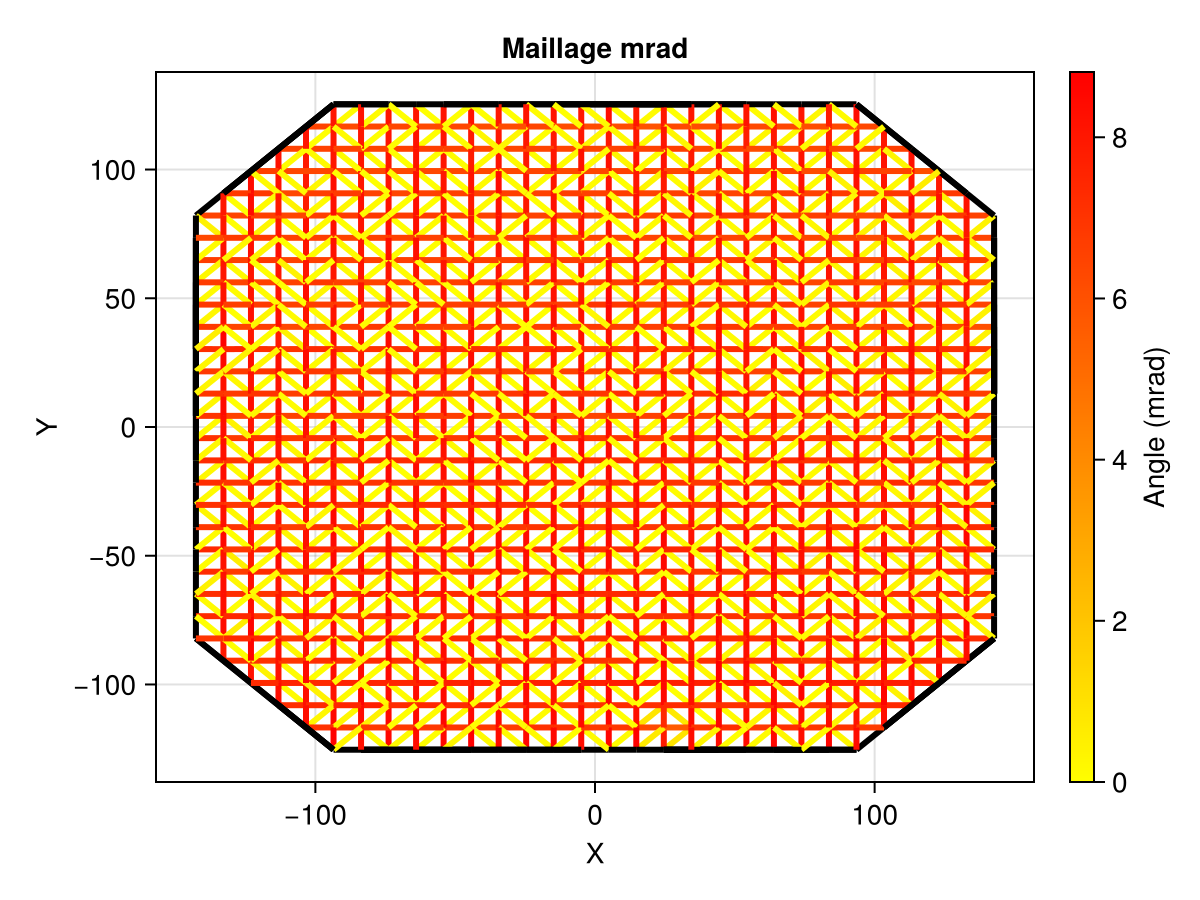

In [192]:
fig = Figure()
ax = Axis(fig[1, 1], title="Maillage mrad", xlabel="X", ylabel="Y")
#hot = reverse(:hot)

for (arete, angle) in angles_aretes
    p1, p2 = points[arete[1]], points[arete[2]]
    if angle != -1
        color = reverse(cgrad(:autumn1))[(angle - min_angle) / (max_angle - min_angle)]
    else
        color = "black"
    end
    lines!(ax, [p1[1], p2[1]], [p1[2], p2[2]], color=color, linewidth=3)
end

# for (arete, angle) in angles_aretes
#     if angle > min_angle
#         p1, p2 = points[arete[1]], points[arete[2]]
#         color = cgrad(:viridis)[(angle - min_angle) / (max_angle - min_angle)]
#         lines!(ax, [p1[1], p2[1]], [p1[2], p2[2]], color=color, linewidth=3)
#     end
# end

# Ajouter une barre de couleur
Colorbar(fig[1, 2], colormap=reverse(cgrad(:autumn1)), label="Angle (mrad)", limits=(min_angle, max_angle))

# Afficher la figure
fig